# 필수 라이브러리 임포트


In [27]:
import torch 
import torchvision
import torch.nn.functional as F
from torch import nn,optim
from torchvision import transforms, datasets


# 모듈 임포트

matplotlib.pyplot -> 이미지 추적 : 오토인코더의 생성 이미지 관찰 
Axes3D -> 맷플롯립에서 3차원 플롯을 그림
cm -> 데이터 포인터에 색상을 입힘
numpy -> 행렬 변환 

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

# 하이퍼파라미터 

In [29]:
EPOCH = 10 
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device: ", DEVICE)

Using Device:  cpu


# Fasion MNIST 데이터셋 로딩 

학습 데이터셋


In [30]:
trainset = datasets.FashionMNIST(
    root = './.data',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2 
)


In [31]:
class Autoencoder(nn.Module):
    def __init__ (self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64,12),
            nn.ReLU(),
            nn.Linear(12,3) 
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,28*28),
            nn.Sigmoid()
        )
        
    def forward (self, x):
        encoded = self.encoder(x)
        decoded = self.decoder (encoded)
        return encoded, decoded
    

In [32]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr =0.005)
criterion = nn.MSELoss()

# 노이즈 추가 

 torch.randn( )으로 무작위의 잡음을 만든다.
 입력에 이미지 크기를 넣어 이미지와 같은 크기의 잡음을 만든다.

 noisy_img = img + noise : 이미지에 노이즈 추가 

In [33]:
def add_noise(img):
    noise = torch.randn(img.size())*0.2 
    noisy_img = img + noise
    return noisy_img 
                        

In [34]:
def train( autoencoder, train_loader ):
    autoencoder.train()
    avg_loss = 0
    for step, (x,label) in enumerate(train_loader):
        x = add_noise(x)  # 입력에 노이즈 추가 
        x = x.view(-1,28*28).to(DEVICE)
        y = x.view(-1,28*28).to(DEVICE)
        
        label = label.to(DEVICE)
        
        encoded, decoded = autoencoder(x)
        
        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
        
    return avg_loss/len(train_loader)
        

In [35]:
for epoch in range(1, EPOCH+1):
    loss = train (autoencoder, train_loader)
    print("[ EPOCH {} ] loss : {}".format(epoch,loss))
    

[ EPOCH 1 ] loss : 0.07877637910992225
[ EPOCH 2 ] loss : 0.06614887568631025
[ EPOCH 3 ] loss : 0.06479434725810597
[ EPOCH 4 ] loss : 0.0641796330510299
[ EPOCH 5 ] loss : 0.06381127826059296
[ EPOCH 6 ] loss : 0.06349810584188142
[ EPOCH 7 ] loss : 0.06332210142379885
[ EPOCH 8 ] loss : 0.06306786554009676
[ EPOCH 9 ] loss : 0.06290402932207721
[ EPOCH 10 ] loss : 0.06275010144691477


# 잡음제거 시각화 

새로운 데이터를 추가한다. 

In [36]:
testset = datasets.FashionMNIST(
    root = './.data',
    train = False, #테스트텟을 만든다. 
    download = True,
    transform = transforms.ToTensor()
)

In [37]:
sample_data = testset.test_data[0].view(-1,28*28) # 0번째 이미지를 입력으로 사용 
sample_data = sample_data.type(torch.FloatTensor )/ 255.


# 복원된 이미지 확인 

In [38]:
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE) # 잡음을 더하고 모델에 통과 
_, recoverd_x = autoencoder (noisy_x) #"_"는 파이썬에서 특정값 무시 

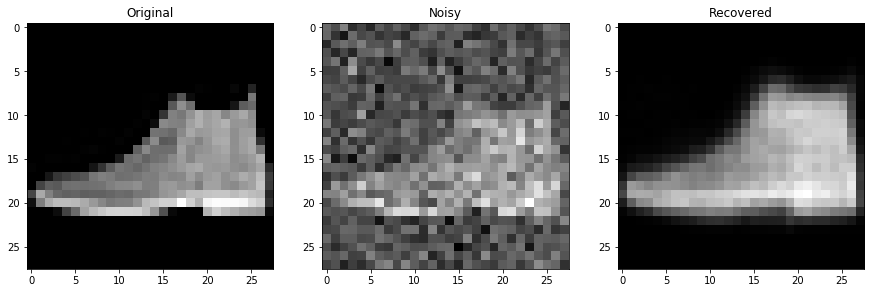

In [41]:
f, a = plt.subplots(1,3, figsize = (15,15)) #1행 3열 이미지 크기는 15*!5 

# 넘파이 행렬로 변환 
original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(),(28, 28))
recoverd_img = np.reshape(recoverd_x.to("cpu").data.numpy(),(28, 28))

#원본사진
a[0].set_title('Original') # 함수 제목 지정
a[0].imshow(original_img, cmap = 'gray')

#오염된 원본 사진
a[1].set_title('Noisy')# 함수 제목 지정
a[1].imshow(noisy_img, cmap = 'gray')

#복원된 사진 
a[2].set_title('Recovered')# 함수 제목 지정
a[2].imshow(recoverd_img, cmap = 'gray')